# Account iteration study (supect users)

## Import

In [ ]:
import pandas as pd
import json

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


import sys
import importlib

sys.path.insert(0, '../')
import general_utils as gen_ut

sys.path.insert(0, '../3_Hashtag_study')
import hashtag_util as ut_ht

sys.path.insert(0, '../4_URL_study')
import url_util as ut_url

## Function definition

In [ ]:
with open('../1_Dataset_preparation/listControlledUsers.json','r') as file_object:  
      data = json.load(file_object)  

listSuspect = data['Novax']

In [ ]:
def df_preparation(cols,filename='../tweets.csv'):
    columns = list(set(cols + ['id','user_screen_name','rt_user_screen_name','in_reply_to_screen_name']))
    
    df = pd.read_csv(filename,low_memory=False, usecols=columns)
    dfSuspect = pd.DataFrame()
    
    for sus in listSuspect:
        df1 = df.loc[df['user_screen_name'] == sus,:]
        dfSuspect = pd.concat([df1,dfSuspect],ignore_index=True)
        
        df1 = df.loc[df['rt_user_screen_name'] == sus,:]
        dfSuspect = pd.concat([df1,dfSuspect],ignore_index=True)
        
        df1 = df.loc[df['in_reply_to_screen_name'] == sus,:]
        dfSuspect = pd.concat([df1,dfSuspect],ignore_index=True)
        del df1
        
    dfSuspect.drop_duplicates(subset=['id'])
    return dfSuspect

## Link study

In [ ]:
df = df_preparation(['urls','created_at'])
df['created_at'] = pd.to_datetime(df['created_at'], format="%a %b %d %X %z %Y")
df

In [ ]:
dfUrls = ut_url.df_url_counter(df)
dfUrls = ut_url.url_credibility('../1_Dataset_preparation/data/credibility.csv',dfUrls)
dfUrls

In [ ]:
sum(dfUrls['count'])

In [ ]:
n = 20
fig = px.histogram(dfUrls.head(n),y=dfUrls.head(n).index,x='count',
            title="The most %d url used in the tweets"% n,orientation = 'h',color='Class')
fig.update_yaxes(title='URL name')
fig.update_yaxes(categoryorder='total descending')
fig.show()

In [ ]:
#Creation of a dictionary of num of use per date
my_dict = {"url":[],"date":[], "count":[]};
for i in range(len(df)):
    s = df.loc[i,'urls']
    d = df.loc[i,'created_at']
    url = gen_ut.get_string_json(s,'display_url')
    if url:
        url = url[0].split("//")
        url = url[0].split("/")
        
        my_dict["url"].append(url[0])
        my_dict["date"].append(d)
        my_dict["count"].append(1)

dfUseUrl = pd.DataFrame.from_dict(my_dict)
dfUseUrl['Week/Year'] = dfUseUrl['date'].apply(lambda x: "%d-%d" % (x.isocalendar()[1] , x.isocalendar()[0]))
dfUseUrl.drop(['date'], axis=1,inplace=True)

dfUseUrl = dfUseUrl.groupby(['Week/Year', 'url']).sum()
dfUseUrl.reset_index(inplace=True)

dfUseUrl['Week/Year'] =pd.to_datetime(dfUseUrl['Week/Year']+ '-1', format="%W-%Y-%w")
dfUseUrl.sort_values(['Week/Year'],axis = 0,inplace=True,ascending=True)

dfUseUrl

In [ ]:
#All in the same graphic
fig = go.Figure()

for w in dfUrls.head(10).index:
    mask = dfUseUrl['url'] == w
    fig.add_trace(go.Scatter(x=dfUseUrl.loc[mask,'Week/Year'], y=dfUseUrl.loc[mask,'count'],
                    mode='lines+markers',
                    name=w))
fig.update_layout(title='All url history use',xaxis_title='Date',yaxis_title='use count')

fig.show()

In [ ]:
# All in different graphic
for w in dfUrls.head(10).index:
    fig = go.Figure()
    mask = dfUseUrl['url'] == w
    fig.add_trace(go.Scatter(x=dfUseUrl.loc[mask,'Week/Year'], y=dfUseUrl.loc[mask,'count'],
                    mode='lines+markers',
                    name=w))
    fig.update_layout(title="History use of url '%s'"%w,xaxis_title='Date',yaxis_title='use count')

    fig.show()

### Use of different Youtube urls

In [ ]:
#Creating a map of all urls about youtube with the number of uses
listUrls = []
for s in df['urls']:
    urls = gen_ut.get_string_json(s,'display_url')
    for url in urls:
        if "youtu.be" in url or "youtube.com" in url:
            if url:
                #url = url.split("//")
                #url = url[0].split("/")
                listUrls.append(url)


dfUrlsYt = pd.DataFrame()
dfUrlsYt['url'] = listUrls
dfUrlsYt['count'] = 1


dfUrlsYt = dfUrlsYt.groupby('url').sum()
dfUrlsYt.sort_values(['count'], axis = 0,inplace=True,ascending=False)

dfUrlsYt

In [ ]:
n = 20
fig = px.histogram(dfUrlsYt.head(n),y=dfUrlsYt.head(n).index,x='count',
            title="The most %d url about youtube used in the tweets"% n,orientation = 'h')
fig.update_yaxes(title='URL name')
fig.show()

In [ ]:
from urllib.request import urlopen
'''
for i,c in dfUrlsYt.iterrows():
    #if "watch" not in i:
    print("http://"+i,"\t",c['count'])
    urlopen("http://"+i).read()'''

In [ ]:
#Creation of a dictionary of num of use per date
my_dict = {"url":[],"date":[], "count":[]};
for i in range(len(df)):
    s = df.loc[i,'urls']
    d = df.loc[i,'created_at']
    urls = gen_ut.get_string_json(s,'display_url')
    for url in urls:
        if "youtu.be" in url or "youtube.com" in url:
            if url:
                #url = url.split("//")
                #url = url[0].split("/")
                listUrls.append(url)
        
            my_dict["url"].append(url)
            my_dict["date"].append(d)
            my_dict["count"].append(1)

dfUseUrlYt = pd.DataFrame.from_dict(my_dict)
dfUseUrlYt['Week/Year'] = dfUseUrlYt['date'].apply(lambda x: "%d-%d" % (x.isocalendar()[1] , x.isocalendar()[0]))
dfUseUrlYt.drop(['date'], axis=1,inplace=True)

dfUseUrlYt = dfUseUrlYt.groupby(['Week/Year', 'url']).sum()
dfUseUrlYt.reset_index(inplace=True)

dfUseUrlYt['Week/Year'] =pd.to_datetime(dfUseUrlYt['Week/Year']+ '-1', format="%W-%Y-%w")
dfUseUrlYt.sort_values(['Week/Year'],axis = 0,inplace=True,ascending=True)

dfUseUrlYt

In [ ]:
#All in the same graphic
fig = go.Figure()

for w in dfUrlsYt.head().index:
    mask = dfUseUrlYt['url'] == w
    fig.add_trace(go.Scatter(x=dfUseUrlYt.loc[mask,'Week/Year'], y=dfUseUrlYt.loc[mask,'count'],
                    mode='lines+markers',
                    name=w))
fig.update_layout(title='All url history use',xaxis_title='Date',yaxis_title='use count')

fig.show()

In [ ]:
# All in different graphic
for w in dfUrlsYt.head().index:
    fig = go.Figure()
    mask = dfUseUrlYt['url'] == w
    fig.add_trace(go.Scatter(x=dfUseUrlYt.loc[mask,'Week/Year'], y=dfUseUrlYt.loc[mask,'count'],
                    mode='lines+markers',
                    name=w))
    fig.update_layout(title="History use of url '%s'"%w,xaxis_title='Date',yaxis_title='use count')

    fig.show()

### Most shared video avable ([here](http://youtu.be/16PvXtfdmX0 ))
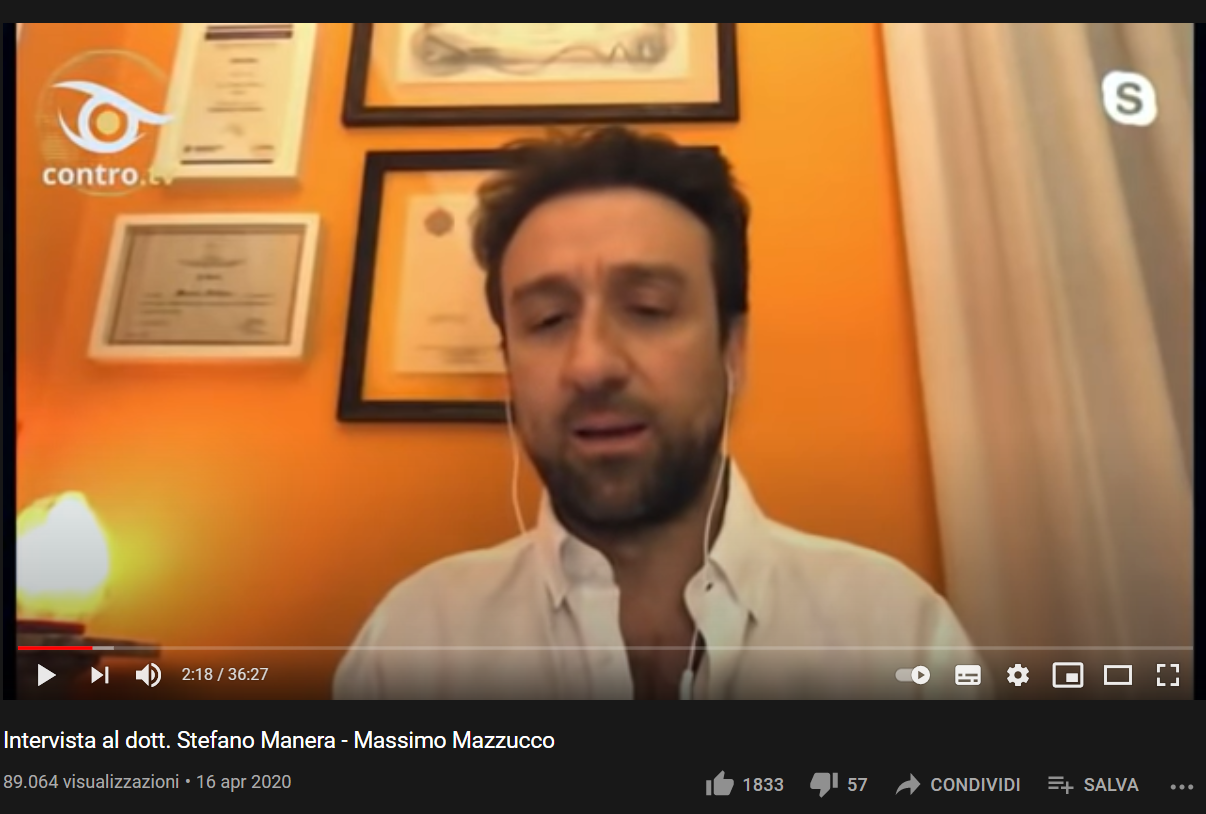

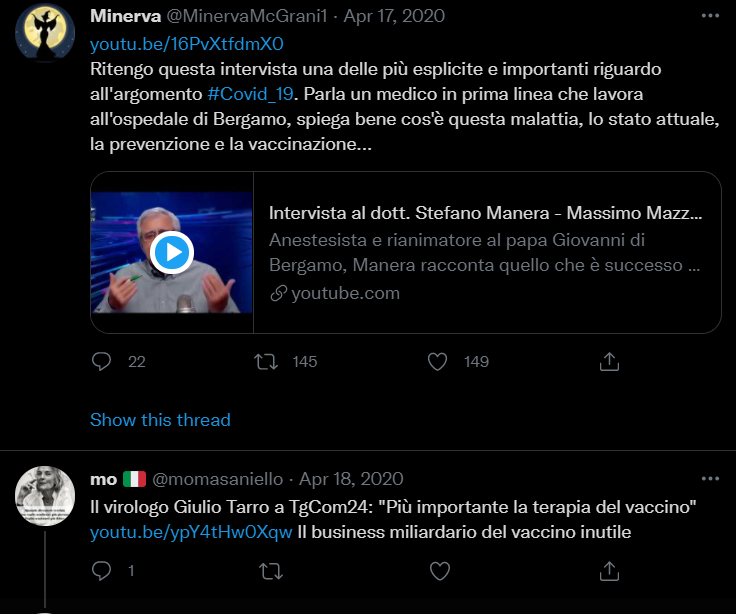

In [ ]:
mask = []
for url in df['urls']:
    mask.append("youtu.be/16PvXtfdmX0" in url)
df[mask]

## Hahstag study

In [ ]:
df = df_preparation(['hashtags','created_at'])
df['created_at'] = pd.to_datetime(df['created_at'], format="%a %b %d %X %z %Y")

In [ ]:
#Creating a map of all hashtags with the number of uses
listHashtags = []

for s in df['hashtags']:    
    [ listHashtags.append(x) for x in gen_ut.get_string_json(s,'text') ]
    
dfHashtags = pd.DataFrame()
dfHashtags['hashtags'] = listHashtags
dfHashtags['count'] = 0

dfHashtags = dfHashtags.groupby('hashtags').count()
dfHashtags.sort_values(['count'],axis = 0,inplace=True,ascending=False)

dfHashtags

In [ ]:
dfUse = ut_ht.process_dfUse(df)
dfUse

In [ ]:
ut_ht.visual_histogram(dfHashtags,150)

In [ ]:
hastagRemove = ['vaccin.*','covid.*','corona.*','astrazeneca','pfizer','sarscov2','sputnikv','moderna']
dfHashtagFiltered = dfHashtags
for r in hastagRemove:
    mask = dfHashtagFiltered.index.str.lower().str.match(r) == True
    dfHashtagFiltered.drop(dfHashtagFiltered[mask].index, inplace=True)
    
dfMoreFiltered = dfHashtagFiltered
hastagRemove = ['.*lombardia.*','draghi','conte','m5s','mattarella','salvini','speranza','renzi','lega','.*governo.*',
           '.*moratti.*','zingaretti','scanzi','burioni','crisanti']
for r in hastagRemove:
    mask = dfMoreFiltered.index.str.lower().str.match(r) == True
    dfMoreFiltered.drop(dfMoreFiltered[mask].index, inplace=True)

ut_ht.visual_histogram(dfMoreFiltered,100)

In [ ]:
ut_ht.visual_by_date_together(dfMoreFiltered,dfUse)

In [ ]:
ut_ht.visual_by_date_split(dfMoreFiltered,dfUse)

## Self retweet

In [ ]:
df = df_preparation(['is_self_rt'])

In [ ]:
dfSelf = df.groupby('user_screen_name').sum()
dfSelf['all_rt'] = df.groupby('user_screen_name').count().iloc[:,0]
dfSelf.sort_values(['all_rt'],inplace=True)
dfSelf

In [ ]:
n = 20
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Bar(y=dfSelf.tail(n).index, x=dfSelf.tail(n)['all_rt'],orientation='h',  name = 'All retweet'), row=1, col=1)
fig.add_trace(go.Bar(y=dfSelf.tail(n).index, x=dfSelf.tail(n)['is_self_rt'],orientation='h', name = 'Self retweet'), row=1, col=1)

fig.update_layout(title="How many retweet are self retweet (the most 20 retweeter)")
fig.update_xaxes(title="Count of retweets")
fig.update_yaxes(title="Username")

fig.update_layout(
    barmode="overlay",
    bargap=0.1)


fig.show()

## Iteration with other users

In [ ]:
df = df_preparation(['is_self_rt'])
df

### Retweet

In [ ]:
dfRetweet = df.dropna(subset=['rt_user_screen_name']).copy()
dfRetweet.drop(columns=['in_reply_to_screen_name'],inplace=True,errors='ignore')
dfRetweet = dfRetweet.groupby('rt_user_screen_name').count()

dfRetweet.rename(columns={'user_screen_name':'all_rt'},inplace=True,errors='ignore')
dfRetweet['self_rt'] = df.dropna(subset=['rt_user_screen_name'
                                        ]).copy().groupby('rt_user_screen_name').sum().loc[:,'is_self_rt']
dfRetweet.drop(columns=['is_self_rt'],inplace=True,errors='ignore')

dfRetweet['real_rt'] = dfRetweet['all_rt'] - dfRetweet['self_rt']
dfRetweet.sort_values('real_rt',ascending=False,inplace=True)
dfRetweet


In [ ]:
n = 20
fig =px.histogram(dfRetweet.head(n),y=dfRetweet.head(n).index,x='real_rt',orientation='h')
fig.update_yaxes(title='username')
fig.update_layout(title="The most %d users retweeted (without self retweet)"%n)
fig.show()
sum(dfRetweet['real_rt'])

### Reply

In [ ]:
dfReply = df.dropna(subset=['in_reply_to_screen_name']).copy()
dfReply.drop(columns=['rt_user_screen_name'],inplace=True,errors='ignore')
dfReply.drop(columns=['is_self_rt'],inplace=True,errors='ignore')

dfReply = dfReply.groupby('in_reply_to_screen_name').count()

dfReply.rename(columns={'user_screen_name':'count'},inplace=True,errors='ignore')
dfReply.sort_values('count',ascending=False,inplace=True)

dfReply

In [ ]:
n = 20
fig =px.histogram(dfReply.head(n),y=dfReply.head(n).index,x='count',orientation='h')
fig.update_yaxes(title='username')
fig.update_layout(title="The most %d users replied"%n)
fig.show()

## Suspect iteration study

In [ ]:
df = df_preparation(['is_self_rt'])
df1 = df.copy()

df1['sum_total_posts'] = 1
df1 = df1.groupby('user_screen_name').sum()

df = df.groupby('user_screen_name').count()
df['sum_total_posts'] = df1['sum_total_posts']
df['sum_self_rt'] = df1['is_self_rt']
del df1

df.rename(columns={'in_reply_to_screen_name':'num_reply','rt_user_screen_name':'num_rt'},inplace=True,errors='ignore')

df['num_reply'] = dfReply
df.loc[df['num_reply'].isna(),'num_reply'] = 0

df['num_rt'] = dfRetweet['real_rt']
df.loc[df['num_rt'].isna(),'num_rt'] = 0

df

In [ ]:
df.describe()

In [ ]:
df.sort_values('num_rt',ascending=False,inplace=True)
df = df.head(10)
df

In [ ]:
n = 20
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Bar(y=df.head(n).index, x=df.head(n)['num_reply'],orientation='h',  name = 'Reply'), row=1, col=1)
fig.add_trace(go.Bar(y=df.head(n).index, x=df.head(n)['num_rt']-df.head(n)['sum_self_rt'],orientation='h', name = 'Retweet'), row=1, col=1)
fig.add_trace(go.Bar(y=df.head(n).index, x=df.head(n)['sum_self_rt'],orientation='h',  name = 'Self retweet'), row=1, col=1)

fig.update_layout(title="How many time this users are retweeted")
fig.update_xaxes(title="Count")
fig.update_yaxes(title="Username")
fig.show()

In [ ]:
for i in range(0,len(df),2):
    fig = make_subplots(rows=1,cols=2,specs=[[{'type':'domain'}, {'type':'domain'}]])
    names = ['Reply', 'Retweet','Tweet','Self retweet']
    
    u = df.index[i]
    if u in listSuspect:
        values = [df.loc[u,'num_reply'], df.loc[u,'num_rt'] - df.loc[u,'sum_self_rt'],
                  df.loc[u,'sum_total_posts']-(df.loc[u,'num_reply']+df.loc[u,'num_rt']),
                 df.loc[u,'sum_self_rt']]
        fig.add_trace(go.Pie(labels = names, values = values,title="%s"%u,textposition='inside')
                      ,row=1,col=1)


        u = df.index[i+1]
        values = [df.loc[u,'num_reply'], df.loc[u,'num_rt'] - df.loc[u,'sum_self_rt'],
                  df.loc[u,'sum_total_posts']-(df.loc[u,'num_reply']+df.loc[u,'num_rt']),
                df.loc[u,'sum_self_rt']]
        fig.add_trace(go.Pie(labels = names, values = values,title="%s"%u,textposition='inside')
                      ,row=1,col=2)

        fig.update_layout(title="Post type division")

        fig.update_traces(marker=dict(colors=['red', 'blue', 'green','cyan']))


        fig.show()